Classify EEG data into Low Workload (background) vs High Workload (task) using Convolutional Neural Networks (Conv2D) with TensorFlow.

In [1]:
!pip install pyedflib numpy pandas scikit-learn matplotlib tensorflow


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 3.5 MB/s eta 0:00:00


In [4]:
!pip install mne --quiet
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import mne


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:
# Load subject-info.csv
df = pd.read_csv(r"C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\subject-info.csv")
df.head()


,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [11]:
df['Label'] = df['Count quality'].map({0: 1, 1: 0})  # 0 → Good → 1, 1 → Bad → 0
df = df[['Subject', 'Label']]
df.head()


,Subject,Label
0,Subject00,1
1,Subject01,0
2,Subject02,0
3,Subject03,0
4,Subject04,1


What are EDF files?
EDF = European Data Format

An EDF file (.edf) is a standardized format for storing bioelectrical signals, such as:

EEG (electroencephalogram – brain activity)

ECG (heart)

EMG (muscles), etc.

It's widely used in medical research and sleep studies. EDF files store:

- Multichannel time-series data (e.g., EEG signals from Fp1, Fp2, Cz, etc.)

- Metadata like patient info, sampling frequency, labels, start time, etc.


To work with them, you’ll primarily use:

- mne: For EEG processing and visualization (modern, flexible)

- pyedflib: For raw reading of EDF signal content and metadata

What is MNE?
mne is a Python library for:
1. Reading, processing, visualizing, and analyzing EEG, MEG, and other neurophysiological data.

2. Especially good for .edf, .bdf, .fif, .set, etc.




Let’s explore one EEG recording to understand:

- Number of channels

- Sampling rate

- Duration

- Signal shape



Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Background EEG Info:
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: 0, sex: 1, last_name: Subject0, birthday: 1990-01-01>
>

Task EEG Info:
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, E

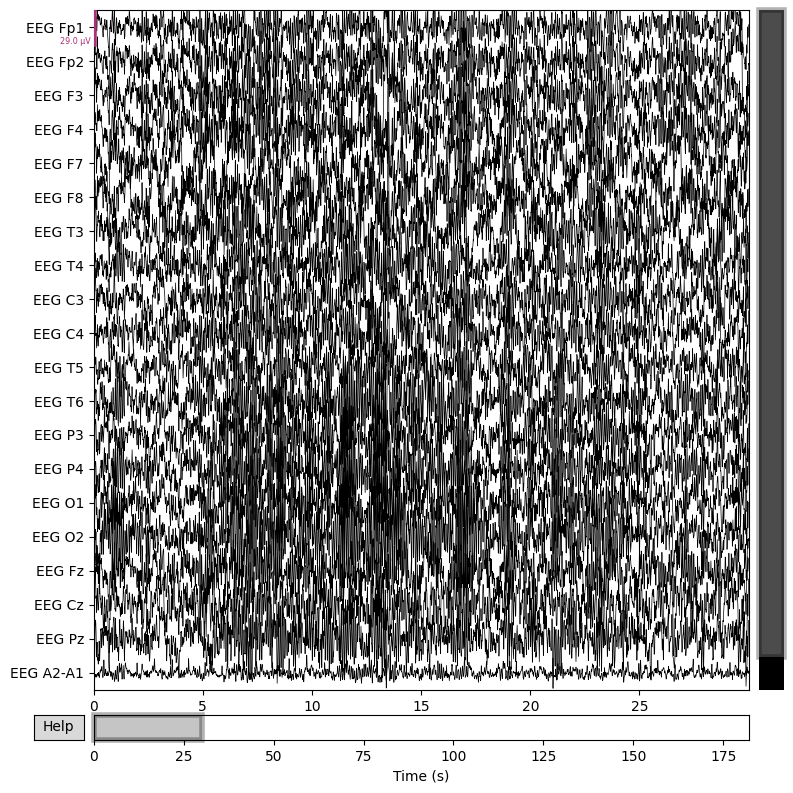

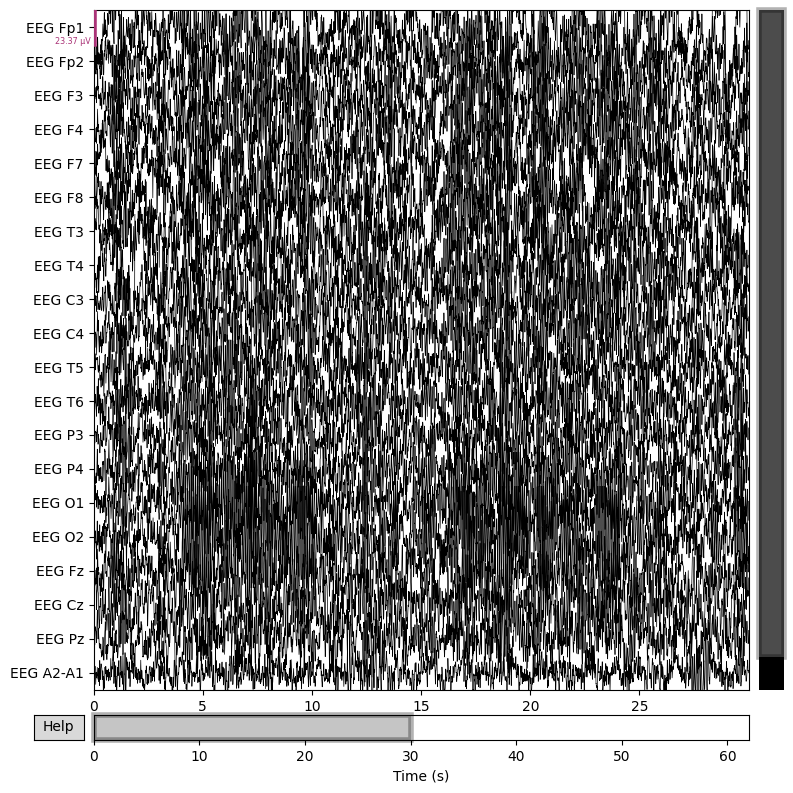

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2714743750.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_bg.plot_psd(fmax=50)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2714743750.py:25: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_task.plot_psd(fmax=50)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


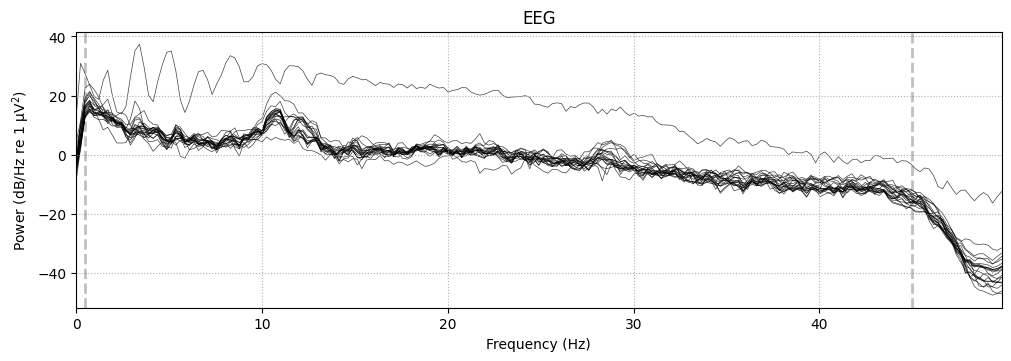

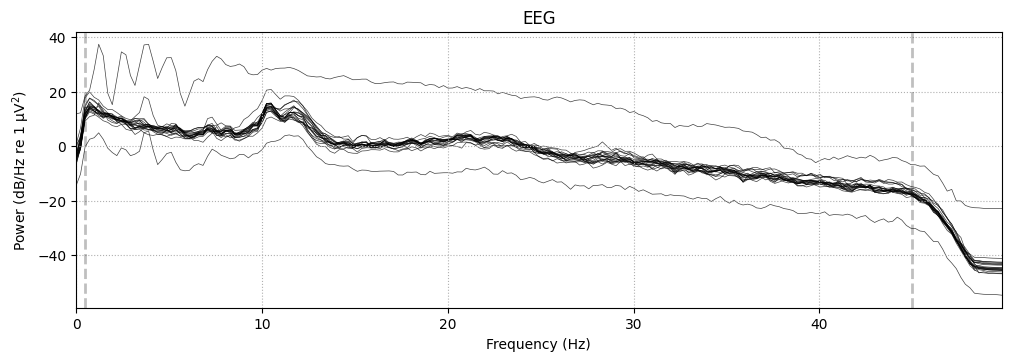

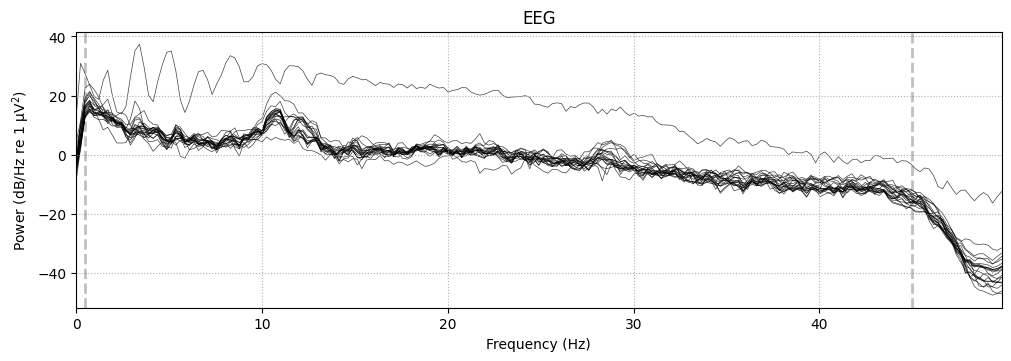

In [12]:
import mne
import matplotlib.pyplot as plt

# File paths for Subject00
file_background = r"C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf"
file_task = r"C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf"

# Load EEG
raw_bg = mne.io.read_raw_edf(file_background, preload=True)
raw_task = mne.io.read_raw_edf(file_task, preload=True)

# Print basic info
print("Background EEG Info:")
print(raw_bg.info)

print("\nTask EEG Info:")
print(raw_task.info)

# Plot waveform (first 30 seconds)
raw_bg.plot(title="Background EEG", duration=30, scalings='auto')
raw_task.plot(title="Task EEG", duration=30, scalings='auto')

# Plot PSD (to see frequency content)
raw_bg.plot_psd(fmax=50)
raw_task.plot_psd(fmax=50)


EEG Data Visualization for Exploration

In [29]:
import os

# 1. Set path to your EEG dataset
data_path = r"C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0"  # UPDATE THIS IF NEEDED

# 2. Get list of all EDF files
edf_files = [f for f in os.listdir(data_path) if f.endswith(".edf")]

# 3. Load all files in a dict
raw_data = {}
for file in edf_files:
    subj_id = file.replace(".edf", "")  # Example: "Subject00_1"
    print(f"Loading {subj_id}...")

    raw = mne.io.read_raw_edf(os.path.join(data_path, file), preload=True)

    # 4. Fix channel names: remove 'EEG ' prefix
    raw.rename_channels(lambda x: x.replace("EEG ", ""))

    # 5. Handle strange channels
    if 'A2-A1' in raw.ch_names:
        raw.rename_channels({'A2-A1': 'A2'})
        raw.set_channel_types({'A2': 'misc'})  # not an EEG channel

    if 'ECG' in raw.ch_names:
        raw.set_channel_types({'ECG': 'ecg'})  # ECG, not EEG

    # 6. Apply standard 10-20 montage
    try:
        raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
    except Exception as e:
        print(f"Montage failed for {subj_id}: {e}")

    # 7. Save in dictionary
    raw_data[subj_id] = raw
raw_bg = raw_data['Subject00_1']


Loading Subject00_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject00_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found


Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject01_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject01_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel


Loading Subject02_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', 

Loading Subject02_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject03_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject03_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject03_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject04_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel


Loading Subject04_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject05_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', 

Loading Subject05_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject05_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject06_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject06_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject07_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject07_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject07_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject08_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject08_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject08_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject08_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject09_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject09_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject09_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject10_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...
Loading Subject10_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject10_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel


Loading Subject11_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject11_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel


Loading Subject11_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject11_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject12_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject12_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', 

Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject12_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject12_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject13_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject13_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject13_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject14_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject14_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject14_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject15_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject15_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject15_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject15_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject16_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject16_1.edf...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject16_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject16_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject17_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject17_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject17_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject17_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel


Loading Subject18_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject18_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject18_2...

C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', 


Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject18_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject19_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject19_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found


Loading Subject19_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject19_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject20_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject20_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject20_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject21_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject21_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject21_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject21_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject22_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject22_1.edf...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject22_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject23_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject23_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject24_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject24_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject24_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject24_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject25_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject25_1.edf...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject25_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject25_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject26_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject26_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject26_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject27_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject27_1.edf...
EDF file detected
Setting channel info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject27_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject27_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject28_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject28_1.edf...
EDF file detected


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject28_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject28_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject29_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject29_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject29_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject29_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject30_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject30_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject31_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Reading 0 ... 39999  =      0.000 ...    79.998 secs...
Loading Subject31_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject31_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject32_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject32_1.edf...
EDF file detected
Setting channel info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject32_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject32_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject33_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject33_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject33_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Loading Subject34_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject34_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject34_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject34_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loading Subject35_1...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Loading Subject35_2...
Extracting EDF parameters from C:\Users\AARUSHI TANDON\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\Subject35_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', on_missing='ignore')  # avoid crashing if not found
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:23: RuntimeWarning: The unit for channel(s) A2 has changed from V to NA.
  raw.set_channel_types({'A2': 'misc'})  # not an EEG channel
C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\2806977014.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider s

In [30]:
raw_bg.ch_names


['Fp1',
 'Fp2',
 'F3',
 'F4',
 'F7',
 'F8',
 'T3',
 'T4',
 'C3',
 'C4',
 'T5',
 'T6',
 'P3',
 'P4',
 'O1',
 'O2',
 'Fz',
 'Cz',
 'Pz',
 'A2',
 'ECG ECG']

In [32]:
raw_bg.set_channel_types({'ECG ECG': 'ecg'})  # mark ECG as non-EEG
raw_bg.set_montage(montage)  # now this should work


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_800\3986620664.py:2: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_bg.set_montage(montage)  # now this should work


<RawEDF | Subject00_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

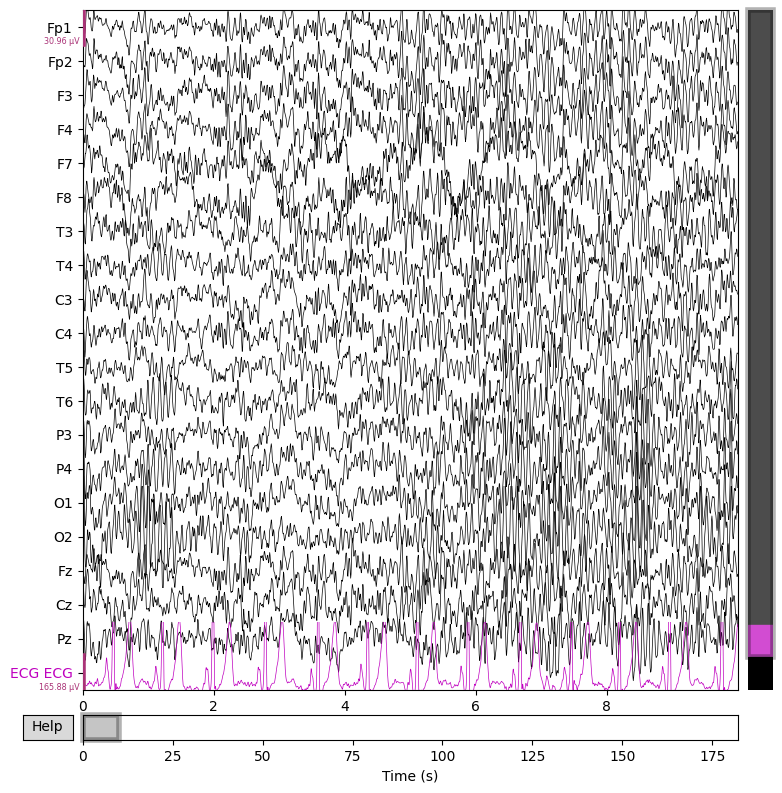

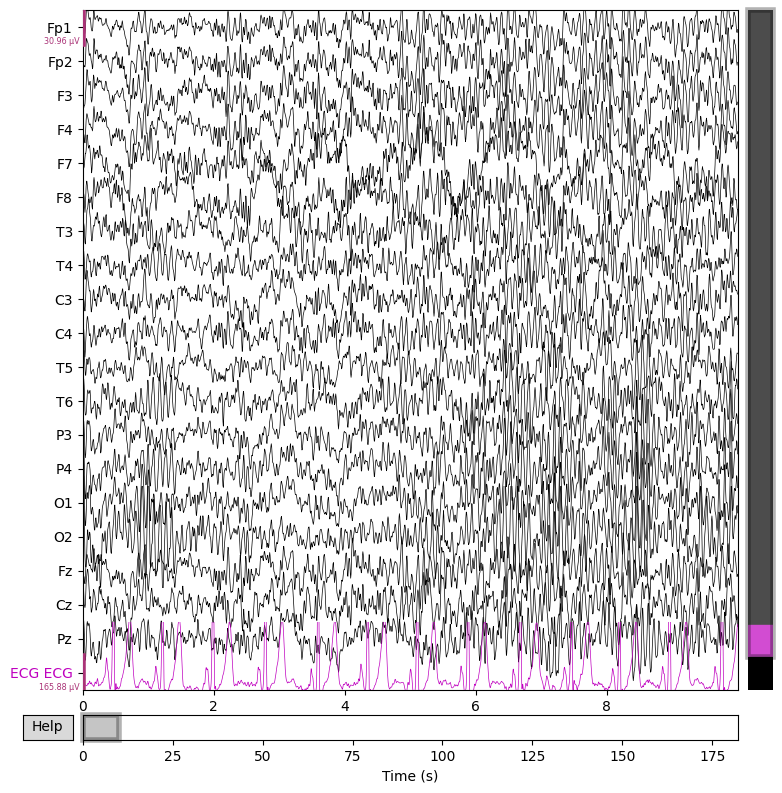

In [33]:
# Plot raw EEG signal for visual inspection
raw_bg.plot(n_channels=20, scalings='auto', duration=10, start=0)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


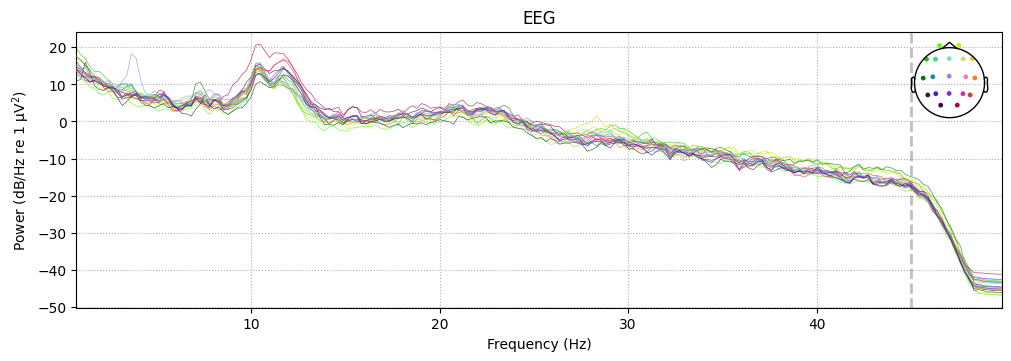

In [34]:
# Plot power spectral density (PSD) to see signal frequency content
raw_bg.plot_psd(fmin=0.5, fmax=50)


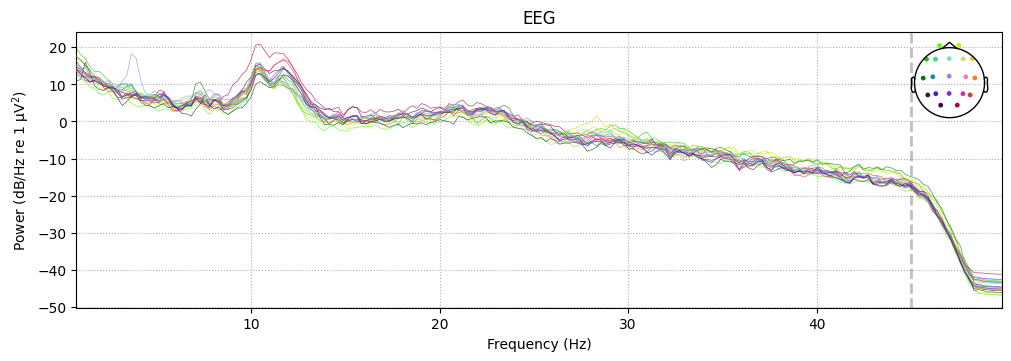

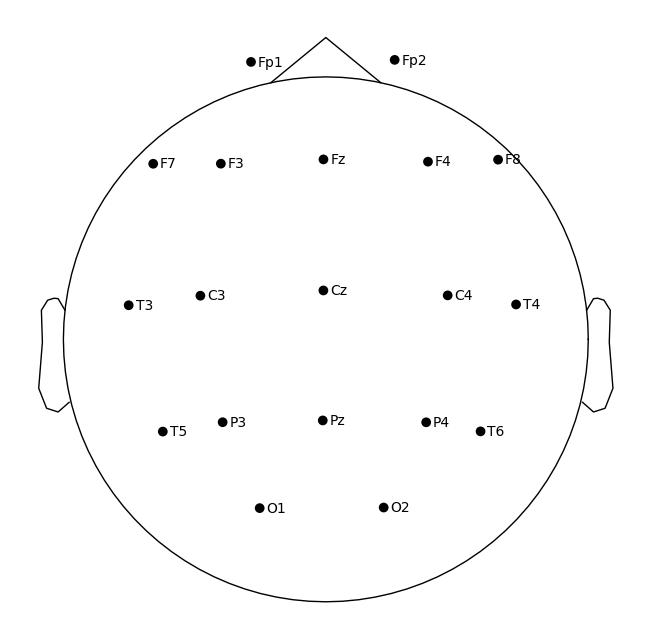

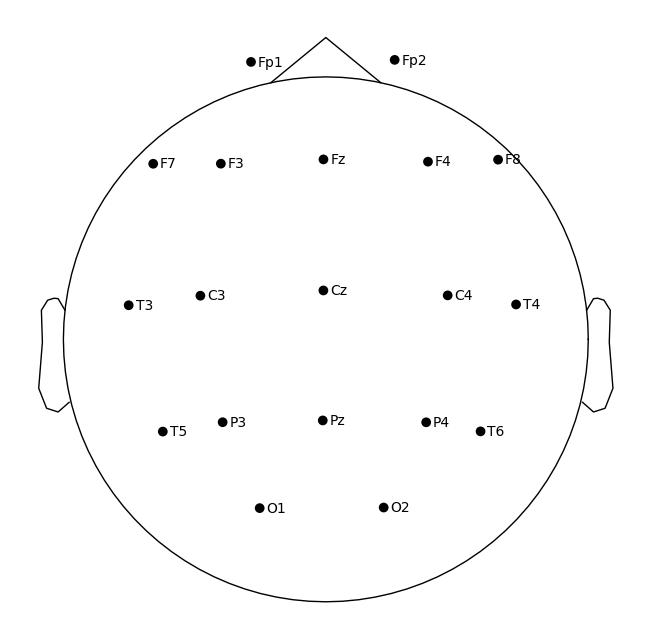

In [35]:
# Topomap at a single time point
raw_bg.plot_sensors(show_names=True)


In [37]:
#Check Signal Info
print(raw_bg.info)


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, F7, F8, T3, T4, C3, C4, T5, T6, P3, P4, O1, ...
 chs: 19 EEG, 1 misc, 1 ECG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: 0, sex: 1, last_name: Subject0, birthday: 1990-01-01>
>


Filtering
- We usually apply bandpass filtering (1–40 Hz) to remove:

- DC drift and skin potentials (<1 Hz)

- Muscle noise and EMG (>40 Hz)

In [38]:
raw_bg_filtered = raw_bg.copy().filter(l_freq=1.0, h_freq=40.0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



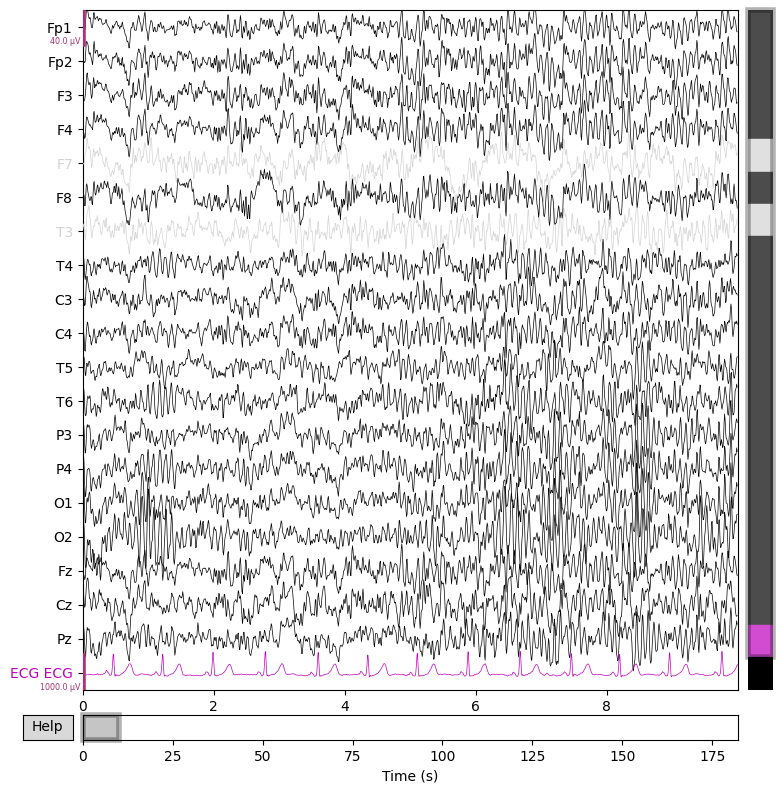

In [40]:
#Artifact Detection - looking for bad channels or noises
raw_bg_filtered.plot()
#If a channel is completely flat or spiky - mark it as bad:
raw_bg_filtered.info['bads'] = ['F7', 'T3']  


Epoching
- EEG is continuous, but we often need to slice it into segments (epochs), especially if we plan to classify or analyze brain states.

-- For mental arithmetic, if you don’t have events/annotations, we can segment it manually:

In [41]:
epochs = mne.make_fixed_length_epochs(raw_bg_filtered, duration=2.0, overlap=1.0)
#This gives overlapping 2-second chunks which is perfect for ML or statistical analysis.



Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated


Power Spectral Density (PSD)

1. This visualizes the frequency content of the EEG.
   
2. Use this to:
- Visually explore brain rhythms
- Spot if alpha, beta, etc. are prominent
- Ensure signal is clean

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 181 events and 1000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


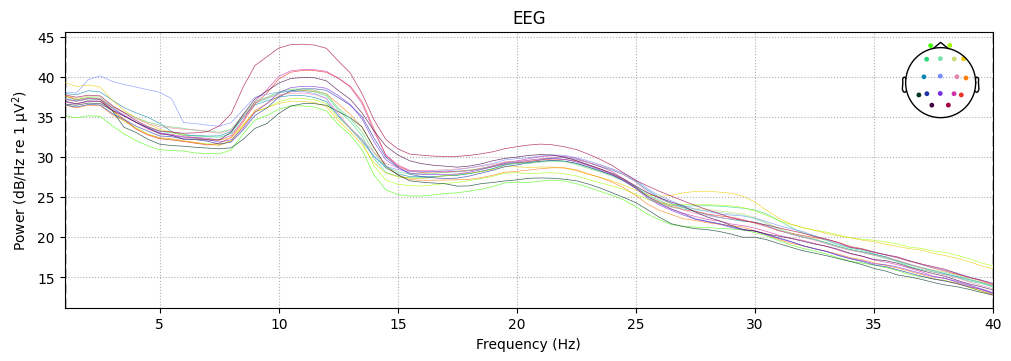

In [42]:
epochs.plot_psd(fmin=1, fmax=40)



In [51]:
import numpy as np
import pandas as pd

# Calculate Power Spectral Density using Welch's method
psds, freqs = raw.compute_psd(fmin=0.5, fmax=45, method='welch').get_data(return_freqs=True)

# Define EEG bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Extract average band power
band_powers = {}
for band, (low, high) in bands.items():
    idx_band = (freqs >= low) & (freqs <= high)
    band_power = psds[:, idx_band].mean(axis=1)
    band_powers[band] = band_power

# Create DataFrame
import pandas as pd
df_band_power = pd.DataFrame(band_powers, index=raw.pick_types(eeg=True).ch_names)
print(df_band_power)
print("EEG Channels Used:", raw.pick_types(eeg=True).ch_names)
print("Band Power Rows:", len(band_powers))



Effective window size : 4.096 (s)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
                delta         theta         alpha          beta         gamma
Fp1      2.429804e-11  4.305713e-12  1.352135e-12  7.170942e-13  2.461426e-13
Fp2      8.943022e-12  5.472417e-12  1.353535e-12  6.608116e-13  2.222109e-13
F3       9.625122e-12  4.825963e-12  1.584447e-12  6.110847e-13  1.806620e-13
F4       1.310015e-11  7.027674e-12  1.977619e-12  7.355070e-13  1.859445e-13
F7       9.962466e-12  4.796125e-12  2.520530e-12  7.934399e-13  2.983610e-13
F8       1.391507e-11  2.991406e-12  1.222718e-12  5.762267e-13  1.621124e-13
T3       1.525614e-11  3.050060e-12  1.250308e-12  4.979480e-13  1.878989e-13
T4       1.584359e-11  2.750944e-12  1.239223e-12  5.887865e-13  1.494162e-13
C3       1.062882e-11  3.799574e-12  1.454749e-12  4.923309e-13  1.732988e-13
C4       1.123716e-11  4.493651e-12  1.526518e-12  5.554756e-13  1.661535e-13
T5       1.153136e-11  2.881837

CNN Model:

Step 1: Convert Raw MNE Data to CNN-Ready Format

Step 2: Preprocess Data for CNN

Step 3: Train/Test Split

Step 4: Build Simple CNN using TensorFlow

Step 5: Train the CNN



CNNs need fixed-size 2D arrays, so you’ll convert time-series EEG signals into:

2D matrices: (channels × time)

Labels: binary (1 = Good, 0 = Bad)

We'll first extract epochs (segments of EEG), then convert them into NumPy arrays.

In [55]:
import numpy as np

standard_eeg_channels = [
    'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4',
    'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2',
    'Fz', 'Cz', 'Pz'
]
def get_X_y_from_raw(raw, label, window_size_sec=1.0, step_size_sec=0.5, sfreq=128):
    raw.pick_channels([ch for ch in standard_eeg_channels if ch in raw.ch_names])
    data = raw.get_data()
    windows = []
    step_size = int(sfreq * step_size_sec)
    window_size = int(sfreq * window_size_sec)

    for start in range(0, data.shape[1] - window_size, step_size):
        end = start + window_size
        window = data[:, start:end]
        if window.shape[1] == window_size:  # Make sure time dimension is fixed
            windows.append(window)

    windows = np.array(windows)  # shape: (n_windows, n_channels, time_samples)
    labels = np.full(len(windows), label)
    return windows, labels


In [56]:
X_all = []
y_all = []

for subj_id, raw in raw_data.items():
    base_id = subj_id.split("_")[0]
    label_row = df[df['Subject'] == base_id]
    if label_row.empty:
        print(f"No label found for {base_id}, skipping.")
        continue

    label = label_row['Label'].values[0]
    
    try:
        X, y = get_X_y_from_raw(raw, label)
        X_all.append(X)
        y_all.append(y)
    except Exception as e:
        print(f"Error processing {subj_id}: {e}")

# Now concatenate safely
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print(X_all.shape, y_all.shape)  # (total_windows, 19, time_samples)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [57]:
#Preprocessing: Reshape and Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Reshape to match CNN input: (samples, height, width, channels)
X_all = X_all.reshape((-1, 19, 128, 1)).astype("float32")

# Normalize
X_all = X_all / np.max(X_all)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(19, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 86s 111ms/step - accuracy: 0.7170 - loss: 0.5925 - val_accuracy: 0.7249 - val_loss: 0.5597
Epoch 2/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 76s 103ms/step - accuracy: 0.7266 - loss: 0.5350 - val_accuracy: 0.7356 - val_loss: 0.4993
Epoch 3/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.7441 - loss: 0.4914 - val_accuracy: 0.7746 - val_loss: 0.4642
Epoch 4/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 71s 105ms/step - accuracy: 0.7655 - loss: 0.4737 - val_accuracy: 0.7873 - val_loss: 0.4477
Epoch 5/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 90s 133ms/step - accuracy: 0.7877 - loss: 0.4397 - val_accuracy: 0.8048 - val_loss: 0.4293
Epoch 6/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 70s 104ms/step - accuracy: 0.8047 - loss: 0.4272 - val_accuracy: 0.8121 - val_loss: 0.4161
Epoch 7/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 71s 105ms/step - accuracy: 0.8168 - loss: 0.4076 - val_accuracy: 0.7880 - val_loss: 0.4512
Epoch 8/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 74s 109ms/step - accuracy: 0.8282 - loss: 0

In [60]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


423/423 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8231 - loss: 0.3950
Test accuracy: 0.8261


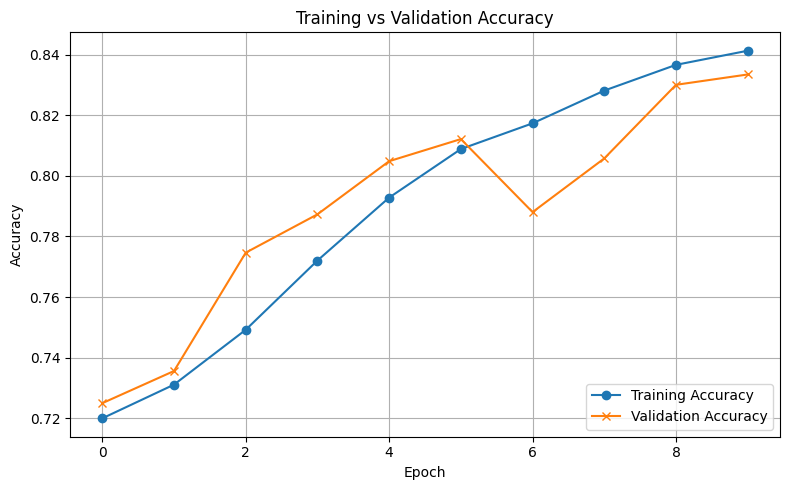

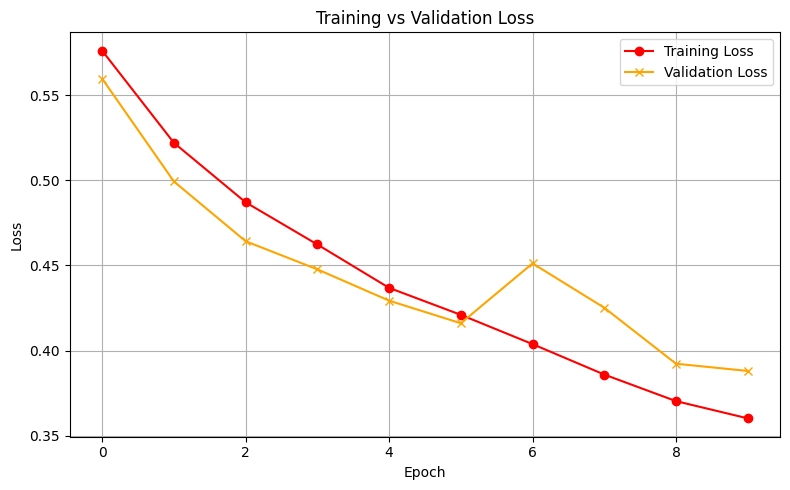

In [63]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predicted classes
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # For softmax output

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="plasma", values_format="d")
plt.title(" Cognitive Load - Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


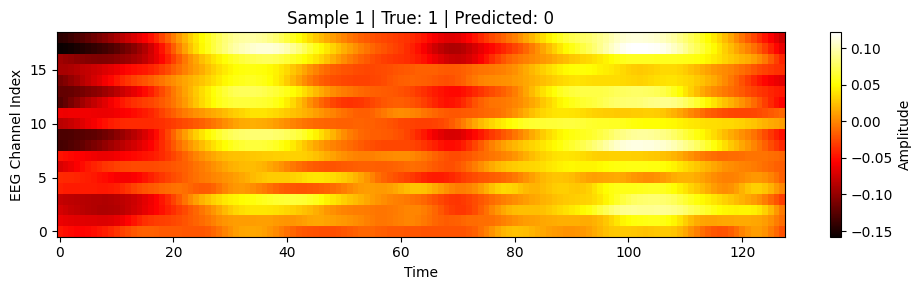

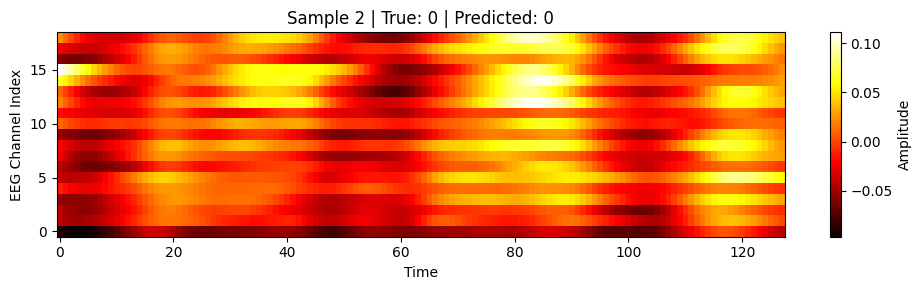

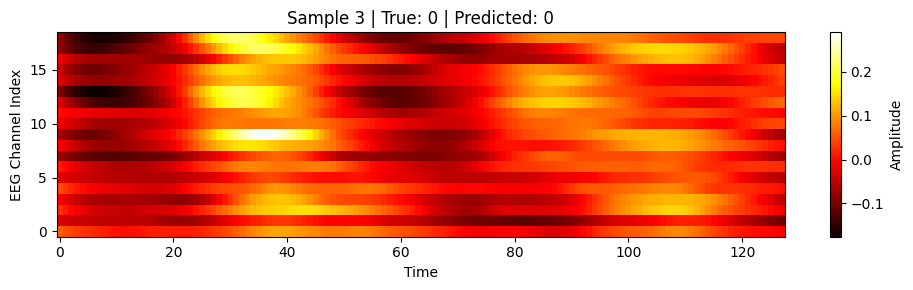

In [68]:
import random
import matplotlib.pyplot as plt

# Select 5 random indices from test set
indices = random.sample(range(len(X_test)), 3)
sample_eeg = X_test[indices]
true_labels = y_test[indices]
predicted_labels = model.predict(sample_eeg).argmax(axis=1)

# Plot each EEG sample as a heatmap
for i in range(len(sample_eeg)):
    plt.figure(figsize=(10, 3))
    plt.imshow(sample_eeg[i], aspect='auto', cmap='hot', origin='lower')
    plt.title(f"Sample {i+1} | True: {true_labels[i]} | Predicted: {predicted_labels[i]}")
    plt.colorbar(label='Amplitude')
    plt.xlabel("Time")
    plt.ylabel("EEG Channel Index")
    plt.tight_layout()
    plt.show()
